<a href="https://colab.research.google.com/github/liminovna/HSE_NLP_ASSIGNMENTS/blob/main/module3_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание № 9

# Задание 1 (10 баллов)

Визуализируйте attention для одного любого текста после нескольких последовательных эпох обучения, чтобы проанализировать как модель учится понимать текст.
Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)
![](https://www.kdnuggets.com/wp-content/uploads/How_to_Visualize_Model_Internals_and_Attention_in_Hugging_Face_Transformers_3.png)

In [1]:
!pip install rusenttokenize
!pip install tokenizers

In [2]:
import pandas as pd
from rusenttokenize import ru_sent_tokenize

In [3]:
data = pd.read_csv('https://github.com/mannefedov/compling_nlp_hse_course/raw/refs/heads/master/data/lenta_40k.csv.zip')

In [4]:
sentences = []
for text in data.text.values:
    sentences.extend(ru_sent_tokenize(text))

In [5]:
# почти 500 тыс предложений
len(sentences)

489727

In [6]:
# cохраним в отдельный файл чтобы больше не тратить время на токенизацию,
# также файл понадобится дальше для обучения токенизатора
f = open('corpus.txt', 'w')
for sent in sentences:
    f.write(sent + '\n')
f.close()

In [7]:
sentences = open('corpus.txt').read().splitlines()

In [8]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers import decoders

In [9]:
tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"], end_of_word_suffix='</w>')

In [10]:
# токенайзер обучается на файле а не на питоновских списках
tokenizer.train(files=["corpus.txt"], trainer=trainer)

In [11]:
# сохраним токенизатор
tokenizer.save('tokenizer')

In [12]:
# при перезапуске можно просто перезагрузить готовый токенизатор
# также он понадобится если мы решим сохранить модель
tokenizer = Tokenizer.from_file("tokenizer")

In [13]:
tokenizer.decoder = decoders.BPEDecoder()
vocab_size = tokenizer.get_vocab_size()

In [14]:
def encode(text, tokenizer):
    return [tokenizer.token_to_id('[BOS]')] + tokenizer.encode(text).ids + [tokenizer.token_to_id('[EOS]')]

In [15]:
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [16]:
import torch

In [17]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, sentences, tokenizer, max_len=32):
        # каждое предложение преобразуется в последовательность индексов
        # а списки преобразуются в тензоры
        self.encoded_texts = [torch.LongTensor(encode(sent, tokenizer)[-max_len:]) for sent in sentences]
        # чтобы составить один общий обучающий тензор нужно сравнять длины последовательностей отдельных текстов
        # в торче не такая удобная функция паддинга, поэтому транкация (отрезание лишнего) происходит уже выше
        self.X = torch.nn.utils.rnn.pad_sequence(self.encoded_texts, padding_value=PAD_IDX, batch_first=True)
        self.length = len(self.encoded_texts)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        # обучающий пример для GPT составляется из одного текста
        # x - это все токены кроме последнего
        # y - это все токены кроме первого
        # другими словами, y это x со сдвигом вправо
        # каждый отдельный элемент в y - следующий токен для соответствующего элемента в x
        # tokens = [1,2,3,4,5,0]
        # x = [1,2,3,4,0]
        # y = [2,3,4,5,0]

        # 1 -> 2
        # 1,2 -> 3
        # 1,2,3 -> 4
        # 1,2,3,4 -> 5
        # teacher forcing

        x = self.X[index][:-1]
        y = self.X[index][1:]

        # чтобы не учитывать паддинг нам нужно создать маску
        mask = x!=PAD_IDX

        return x, y, mask

In [18]:
n = int(0.9*len(sentences)) # first 90% will be train, rest val
sentences_train = sentences[:n]
sentences_val = sentences[n:]

In [19]:
MAX_LEN = 64

In [20]:
training_set = Dataset(sentences_train, tokenizer, MAX_LEN)
val_set = Dataset(sentences_val, tokenizer, MAX_LEN)

In [21]:
training_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True, )
val_generator = torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=False)

In [22]:
# в коде часто встречается вот такой импорт
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
# hyperparameters
block_size = MAX_LEN # what is the maximum context length for predictions?
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 # размерность эмбеддингов и векторов внутри трансформера
#ffn_hid_dim = n_embd * 4
n_head = 4
n_layer = 4
dropout = 0.0

Для этого вам понадобится так изменить код модели из семинара, чтобы Block класс возвращал attention активации (последнее значение wei), а также все остальные классы, которые вызывают Block, чтобы они ожидали, что модель вернет не только out но и wei. В самом верхнеуровневом классе BigramLanguageModel вы можете добавить атрибут last_attentions и в forward перезаписывать его значения последним значением attention (но можно придумать и другой способ). После каждой эпохи вызовите модель на одном примере из датасета и сохраните last_attentions во внешнюю переменную, чтобы потом отдельно заняться визуализацией. Визуализируйте attentions как heatmap'ы (например в searborn). У вас будет attention матрица для каждого слоя и для каждого head в модели. Для каждой нужно будет сделать свой хитмап.
Должно получиться что-то похожее на (только несколько для каждой эпохи)

In [24]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        if mask is not None:
            wei.masked_fill(~mask.unsqueeze(1), float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out, wei

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        out_list = []
        wei_list = []
        for h in self.heads:
          out_, wei_ = h(x, mask)
          out_list.append(out_)
          wei_list.append(wei_)
        out = torch.cat(out_list, dim=-1)
        out = self.dropout(self.proj(out))
        return out, wei_list

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa_ = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, inp):
        # print('inp', inp[-1])
        x, mask, attentions = inp
        sa, attentions = self.sa_(self.ln1(x), mask)
        x = x + sa
        x = x + self.ffwd(self.ln2(x))
        return x, mask, attentions

In [25]:
# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, mask=None, attentions=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x, mask, last_attentions = self.blocks((x, mask, attentions)) # (B,T,C)
        # last_attentions = None
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets, ignore_index=PAD_IDX)

        return logits, loss, last_attentions

    def generate(self, idx, max_new_tokens, stop_token):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss, attentions = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)# (B, 1)
            if idx_next == stop_token:
                break
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

In [26]:
model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

4.073392 M parameters


In [27]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [28]:
def train(model, iterator, optimizer, print_every=10):
    epoch_loss = []
    model.train()

    for i, (xs, ys, mask) in enumerate(iterator):
        optimizer.zero_grad()
        # last_attentions = None
        logits, loss, last_attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))

        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())

        if not (i+1) % print_every:
            print(f'Loss: {torch.Tensor(epoch_loss).mean(-1)}')

    return torch.Tensor(epoch_loss).mean(-1), last_attentions

def evaluate(model, iterator):
    epoch_loss = []
    model.eval()
    with torch.no_grad():
        for xs, ys, mask in iterator:
            logits, loss, last_attentions = model(xs.to(device), ys.to(device), mask.to('cuda'))
            epoch_loss.append(loss.item())

    return torch.Tensor(epoch_loss).mean(-1)

In [95]:
train_losses = []
eval_losses = []
last_attentions = {}
for i in range(10):
    print(i)
    res_, attentions_ = train(model, training_generator, optimizer, 100)
    train_losses.append(res_)
    last_attentions[i] = attentions_
    eval_loss = evaluate(model, val_generator)
    print('Eval - ', eval_loss.item())
    eval_losses.append(eval_loss)
    for _ in range(3):
        pred = model.generate(torch.LongTensor([[tokenizer.token_to_id('[BOS]')]]).to('cuda'), 200, tokenizer.token_to_id('[EOS]'))
        print(tokenizer.decoder.decode([tokenizer.id_to_token(i) for i in pred.detach().cpu().numpy()[0]][1:-1]))


0
Loss: 5.739278793334961
Loss: 5.720214366912842
Loss: 5.702942371368408
Loss: 5.690797328948975
Loss: 5.67758846282959
Loss: 5.661170482635498
Loss: 5.648122310638428
Loss: 5.634737968444824
Loss: 5.621982097625732
Loss: 5.60909366607666
Loss: 5.597376823425293
Loss: 5.586092472076416
Loss: 5.57490348815918
Loss: 5.564089775085449
Loss: 5.553274631500244
Loss: 5.543518543243408
Loss: 5.533500671386719
Loss: 5.524563312530518
Loss: 5.514701843261719
Loss: 5.5051093101501465
Loss: 5.4951491355896
Loss: 5.486700057983398
Eval -  5.222429275512695
Из природных ресурсов Facebook может совсем правиться , сколько имеет нормы самого государства , сами города , других представителей банка и ранили не затрагивающих такого значения , которые танцечил режимом на границе . Орравена найден галлена - мымтов
Мы был нашим оптилиным дорожной галереи в список от договора принадлежащей Ваковы фонков », — заявил генеральный секретарь министра аэропортов по информационной политике Набиуллина убежден
Анкар

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [97]:
example = val_set.__getitem__(42)[0].cpu().numpy()
example_tokens = [tokenizer.id_to_token(e) for e in example if tokenizer.id_to_token(e) != '[PAD]']
example_tokens

['[BOS]',
 'Пробле',
 'ма</w>',
 'в</w>',
 'том</w>',
 ',</w>',
 'что</w>',
 'они</w>',
 'могут</w>',
 'вести</w>',
 'свои</w>',
 'тем',
 'ные</w>',
 'дела</w>',
 ',</w>',
 'разговари',
 'вать</w>',
 'без</w>',
 'пере',
 'ры',
 'вов</w>',
 '.</w>',
 '[EOS]']

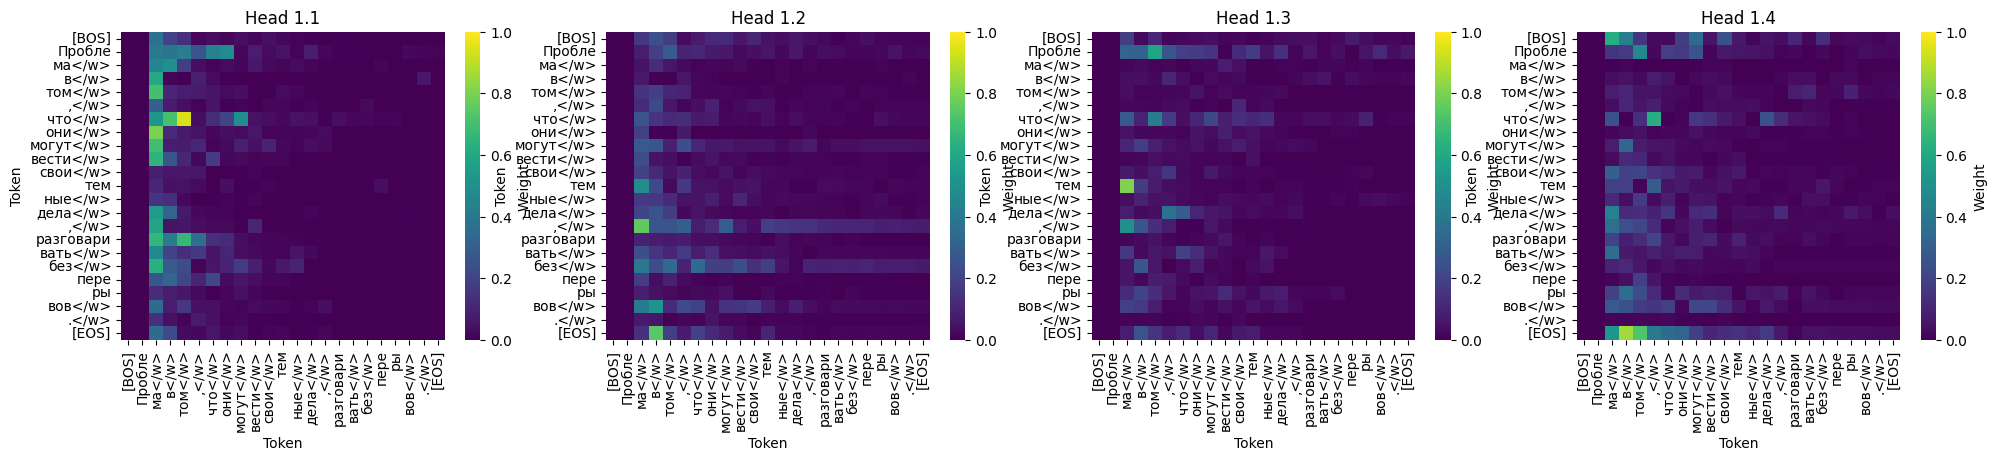

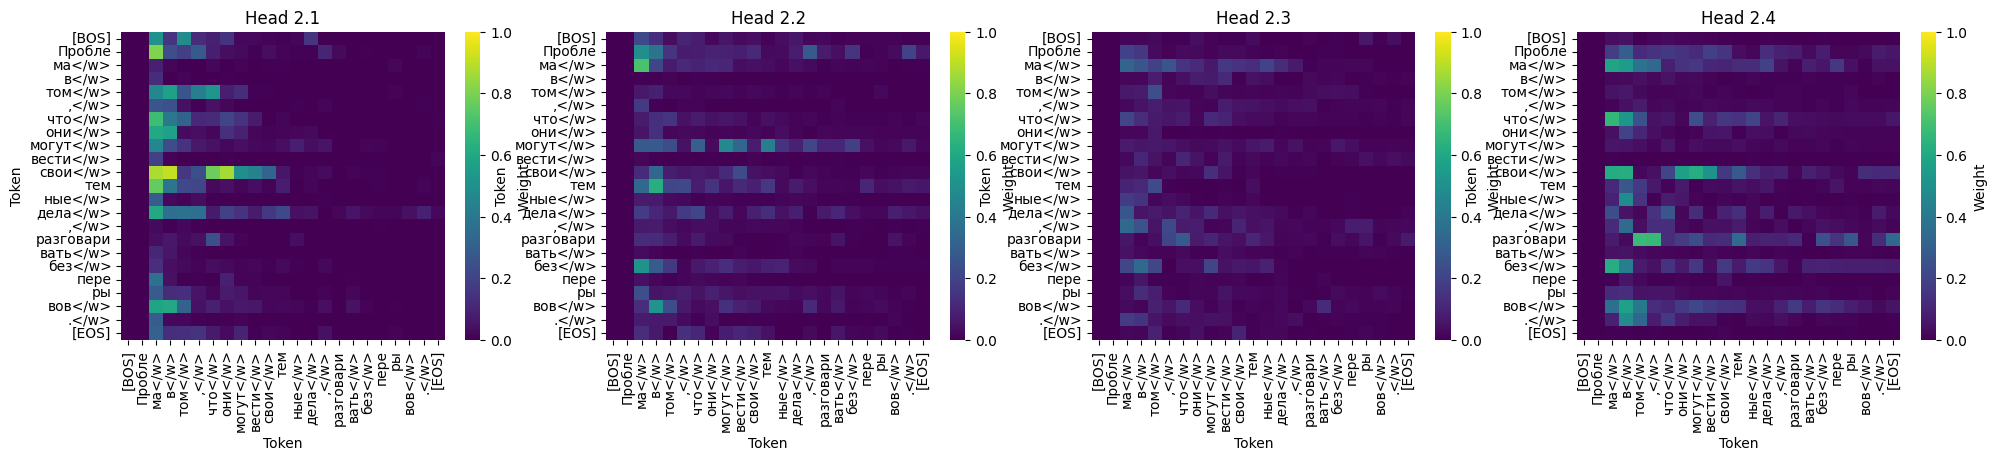

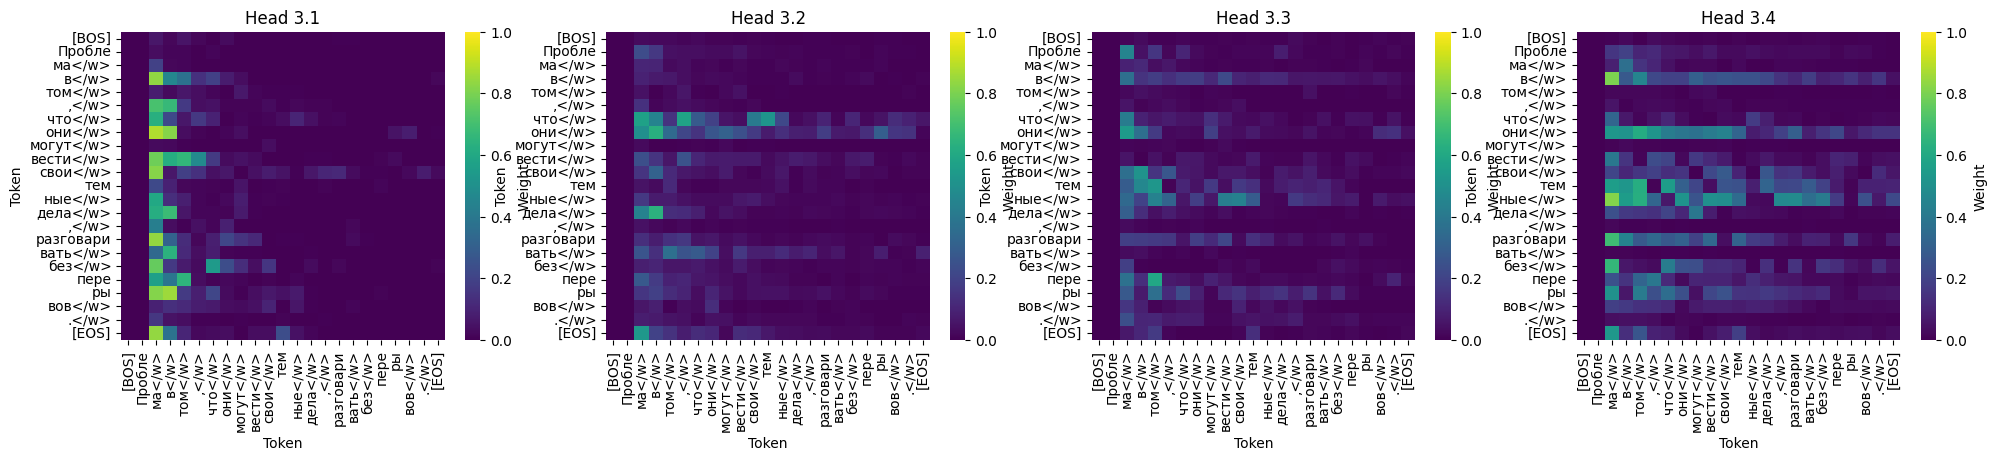

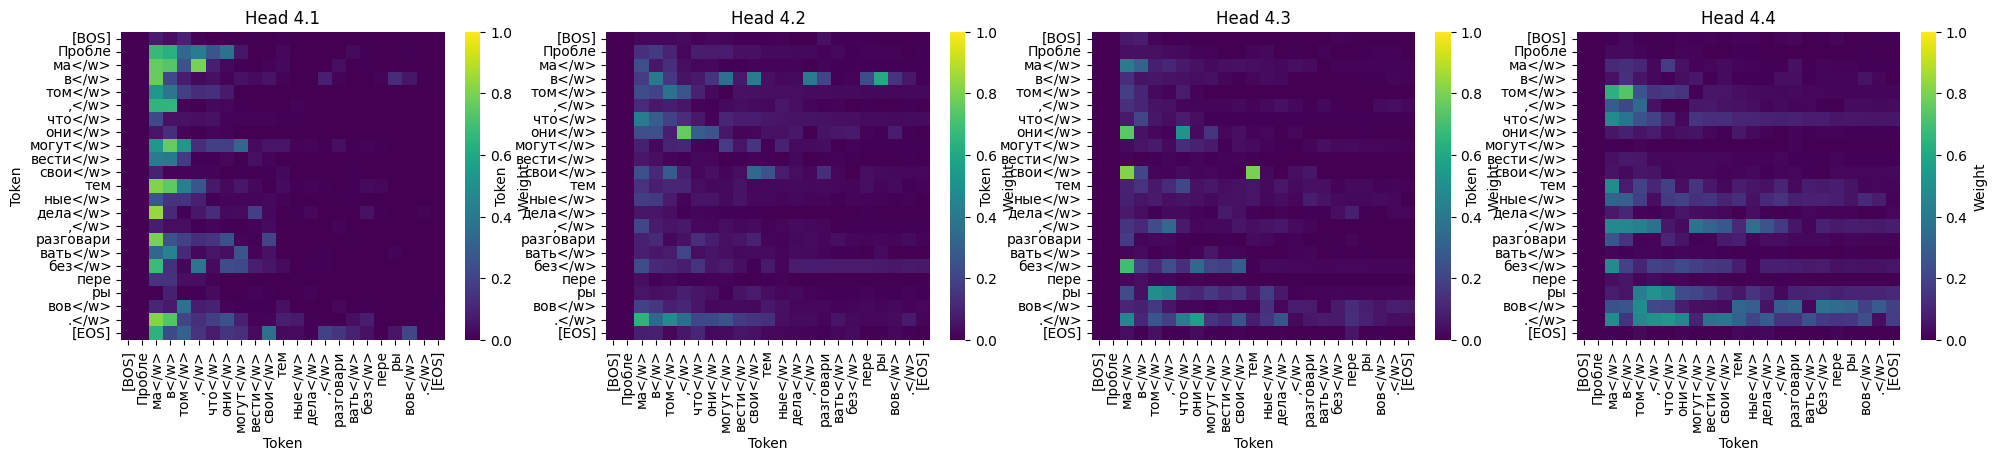

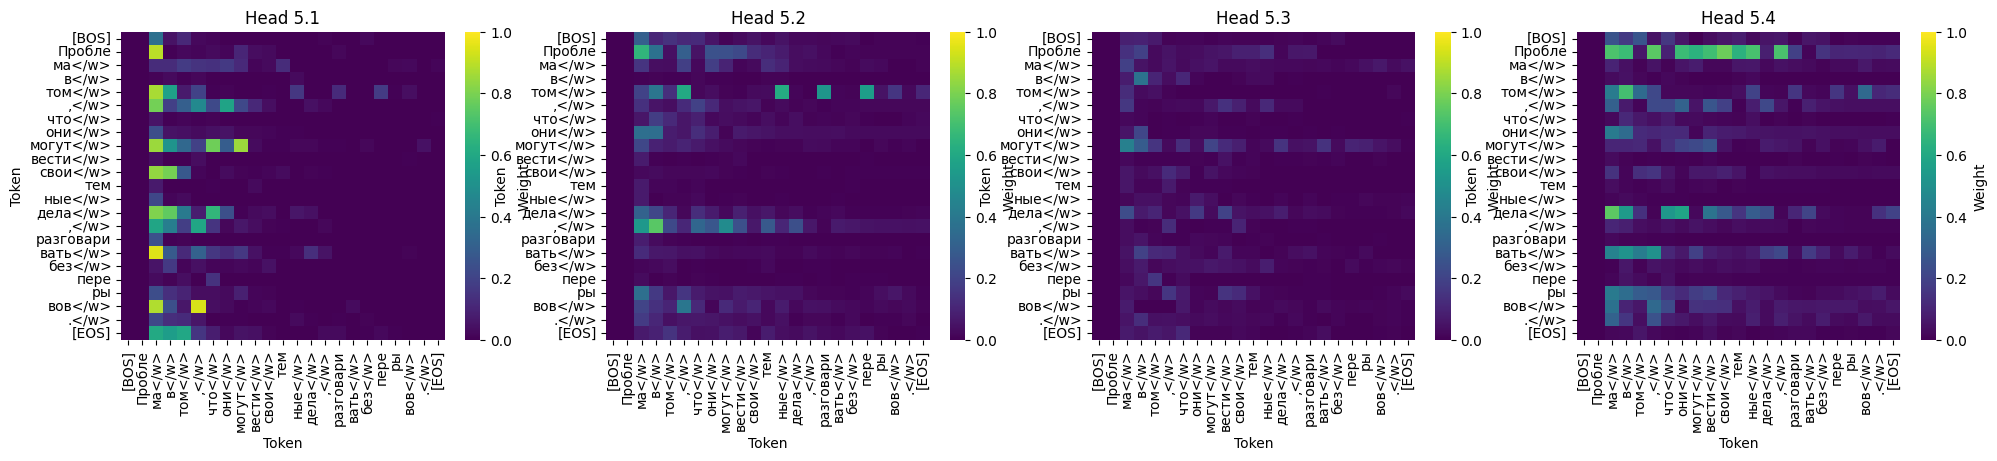

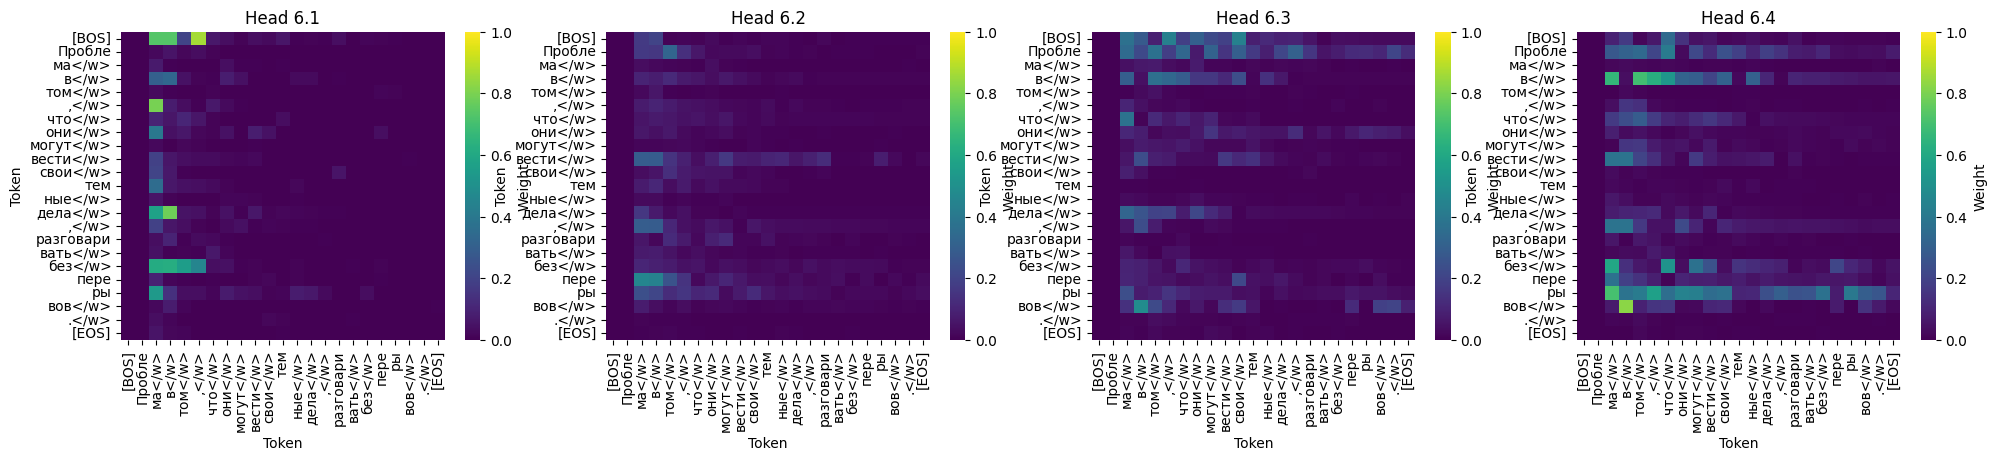

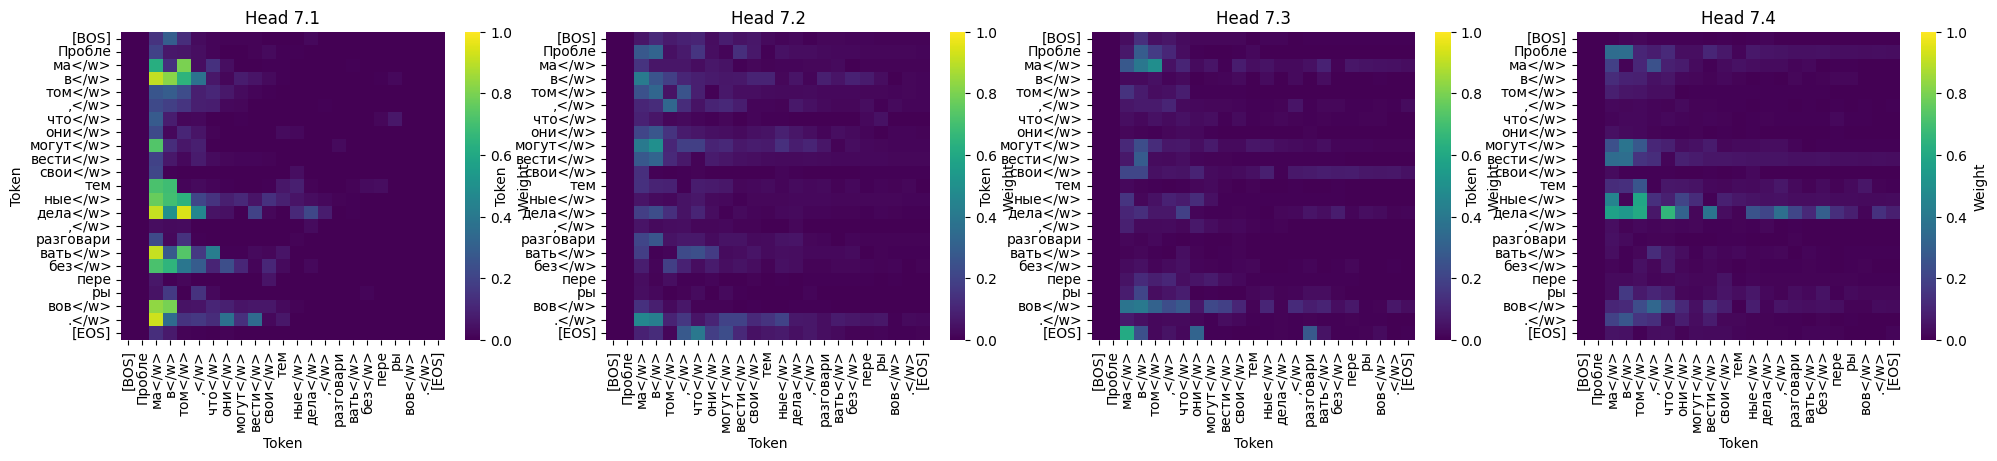

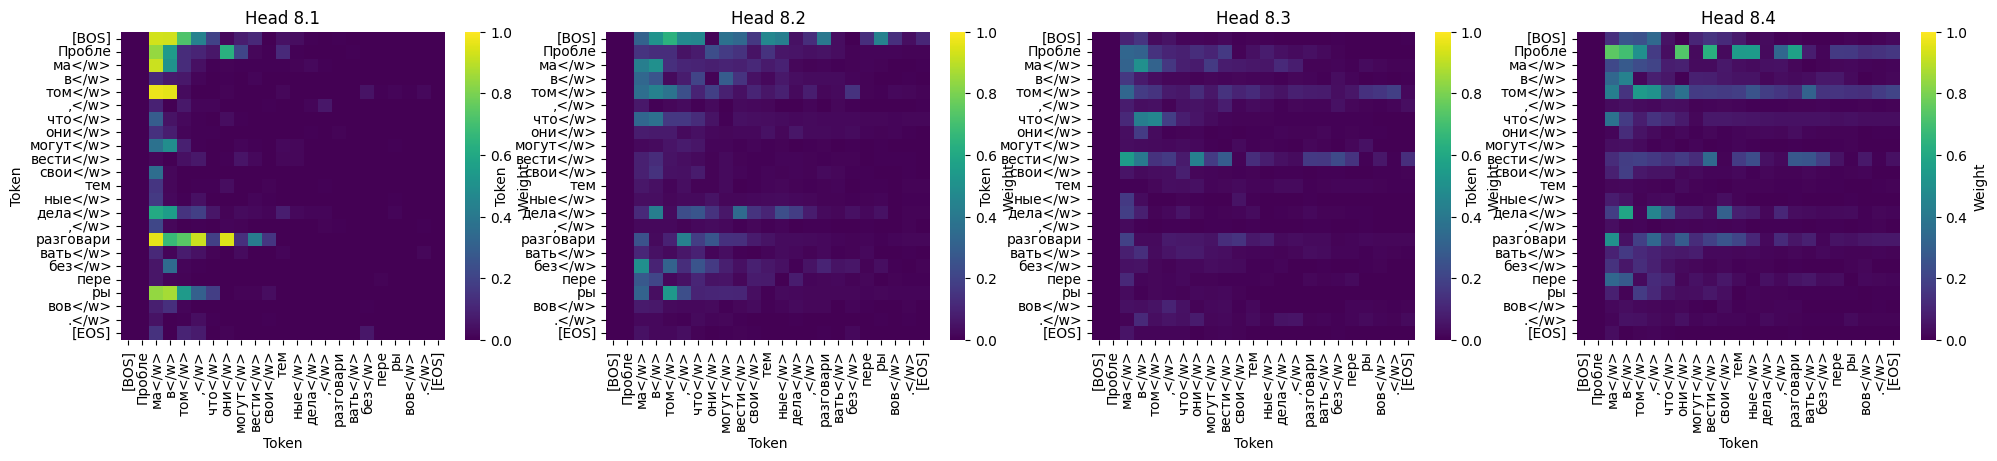

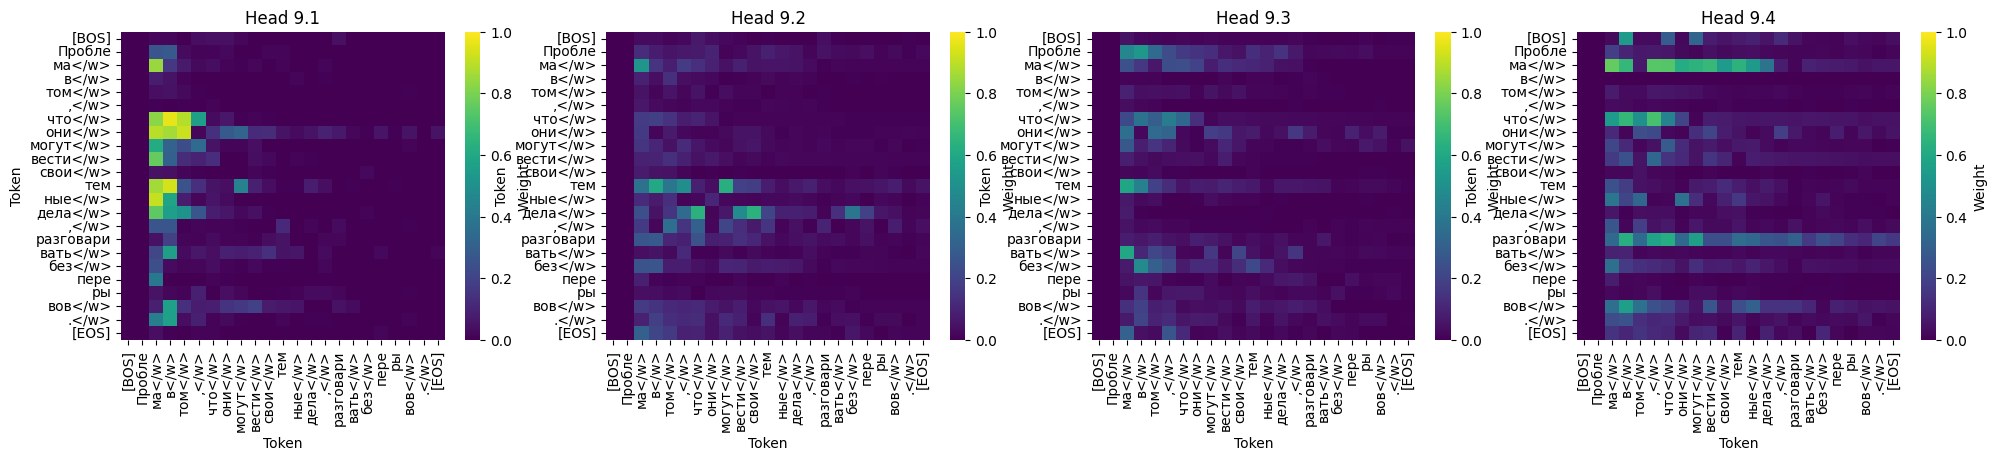

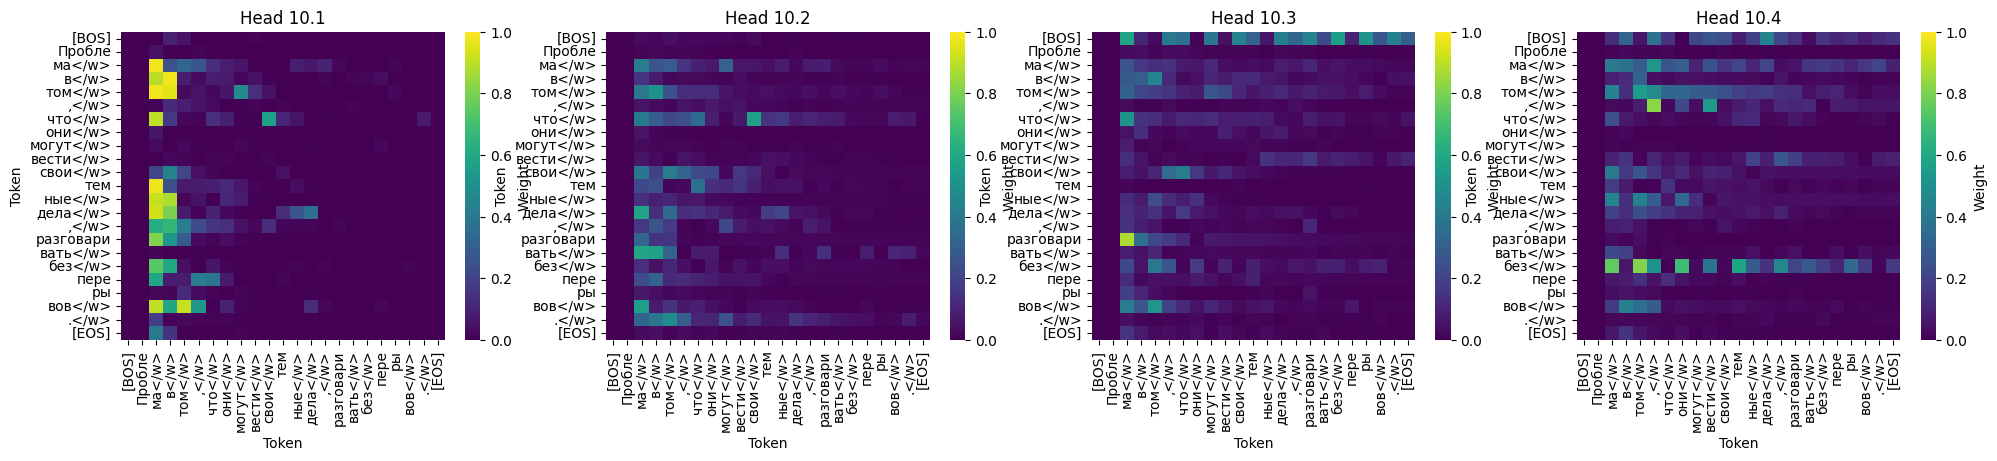

In [102]:
for k, v in last_attentions.items():
    # print(k, v)
    att = [_.squeeze(0).detach().cpu().numpy()[:len(example_tokens), :len(example_tokens)] for _ in v]
    # print([_.squeeze(0)[:len(example_tokens), :len(example_tokens)].shape for _ in v])
    fig, axes = plt.subplots(1, 4, figsize=(6 * 4, 4))
    for idx, attention_matrix in enumerate(att):
        # print(attention_matrix[:, :, 2].shape)
        sns.heatmap(
            attention_matrix[:, :, 2],
            cmap="viridis",
            ax=axes[idx],
            vmin=0,
            vmax=1,
            cbar_kws={"label": "Weight"},
            xticklabels=example_tokens,
            yticklabels=example_tokens,
            )
        axes[idx].set_title(f"Head {k+1}.{idx+1}")
        axes[idx].set_xlabel("Token")
        axes[idx].set_ylabel("Token")